In [ ]:
#According to this article https://arxiv.org/abs/1705.00105.

In [1]:
import torch
import torch.autograd as autograd
from torch.autograd import Variable
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
# import matplotlib as plt
from matplotlib import pyplot as plt
import random
import seaborn as sns
%matplotlib inline
pd.options.display.max_columns = 100

In [2]:
raw_pay_train = pd.read_csv('train.csv')[:300000]
raw_pay_test = pd.read_csv('test.csv')[:300000]

In [3]:
raw_pay_train.shape

(300000, 58)

In [4]:
raw_pay_test.shape

(300000, 59)

In [77]:
raw_pay_train[raw_pay_train.columns[1:]].mean()

0     0.094793
1     0.293893
2     0.107256
3     0.086133
4     0.069720
5     0.088619
6     0.046427
7     0.025312
8     0.023263
9     0.012050
10    0.005016
11    0.013705
12    0.008230
13    0.031046
14    0.011314
15    0.010366
16    0.000819
17    0.003229
18    0.008448
19    0.002703
20    0.006868
21    0.003924
22    0.018710
23    0.002836
24    0.002225
25    0.001605
26    0.005780
27    0.001469
28    0.004426
29    0.000909
30    0.001598
31    0.000508
32    0.000114
33    0.002074
34    0.000451
35    0.000151
36    0.000297
37    0.001140
38    0.000249
39    0.000154
40    0.000586
41    0.000474
42    0.000077
43    0.000293
44    0.000066
45    0.000021
46    0.000225
47    0.000021
48    0.000026
49    0.000031
50    0.000038
51    0.000069
52    0.000010
53    0.000003
54    0.000001
55    0.000007
56    0.000002
dtype: float64

In [79]:
np.array(list(raw_pay_train[raw_pay_train.columns[1:]].mean())).argsort()

array([54, 56, 53, 55, 52, 45, 47, 48, 49, 50, 44, 51, 42, 32, 35, 39, 46,
       38, 43, 36, 34, 41, 31, 40, 16, 29, 37, 27, 30, 25, 33, 24, 19, 23,
       17, 21, 28, 10, 26, 20, 12, 18, 15, 14,  9, 11, 22,  8,  7, 13,  6,
        4,  3,  5,  0,  2,  1])

In [5]:
%%time
non_zero_indexes = np.argwhere((raw_pay_train.iloc[:, :].loc[:, [str(i) for i in list(range(0,57))] ] > 0).values )

CPU times: user 124 ms, sys: 8 ms, total: 132 ms
Wall time: 128 ms


In [6]:
indx_df = pd.DataFrame(non_zero_indexes)  

In [7]:
#indx_df[1] += 1

In [8]:
triplets = pd.merge(indx_df, indx_df, on=indx_df.columns[0])

In [9]:
col = triplets.columns

In [10]:
triplets = triplets[triplets['1_x'] != triplets['1_y']]

In [11]:
raw_pay_train.values

array([[  4.74000000e+02,   0.00000000e+00,   1.10000000e-01, ...,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  2.25000000e+03,   0.00000000e+00,   1.00000000e+00, ...,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  2.45300000e+03,   0.00000000e+00,   1.20000000e-01, ...,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       ..., 
       [  2.09340000e+04,   1.00000000e-02,   9.80000000e-01, ...,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  3.41410000e+04,   0.00000000e+00,   0.00000000e+00, ...,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  4.46740000e+04,   0.00000000e+00,   9.20000000e-01, ...,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00]])

In [13]:
%%time
train_data = raw_pay_train.values    
trip_data = triplets.values
l = triplets.shape[0]
val = np.zeros(l)
for i in range(l):
    row = trip_data[i][0]
    x = trip_data[i][1] + 1
    y = trip_data[i][2] + 1
    if train_data[row][x] >= train_data[row][y]:
        val[i] = 1.
    else:
        val[i] = -1.

CPU times: user 6.73 s, sys: 12 ms, total: 6.74 s
Wall time: 6.75 s


In [14]:
train_data

array([[  4.74000000e+02,   0.00000000e+00,   1.10000000e-01, ...,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  2.25000000e+03,   0.00000000e+00,   1.00000000e+00, ...,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  2.45300000e+03,   0.00000000e+00,   1.20000000e-01, ...,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       ..., 
       [  2.09340000e+04,   1.00000000e-02,   9.80000000e-01, ...,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  3.41410000e+04,   0.00000000e+00,   0.00000000e+00, ...,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  4.46740000e+04,   0.00000000e+00,   9.20000000e-01, ...,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00]])

In [15]:
triplets = triplets.assign(val=val)
tripl_data = triplets.values

In [22]:
%%time
new_indexes = np.zeros(l)
for i in range(l):
    row = int(tripl_data[i][0])
    new_indexes[i] = int(train_data[row][0])

CPU times: user 4.16 s, sys: 0 ns, total: 4.16 s
Wall time: 4.17 s


In [24]:
#for row, idx_col in indx_df.groupby(0):
 #   print(row)
  #  print(idx_col[1])
   # break

In [25]:
triplets[col[0]] = new_indexes.astype(int)

In [26]:
triplets = triplets.rename(columns={col[0]: 'user_id'})

In [28]:
#big_pay = pd.concat([slice_pay_train, slice_pay_test])

In [58]:
def get_random_sample(triplets, N=84):
    #indexes = np.random.randint(len(triplets), size=N)
    indexes = random.sample(range(0, len(triplets)), N)
    return triplets.iloc[indexes]

def torch_mean_logloss(raw_margins, target_values, trunc_max=100.):
    # -y * f(x), минус уже учтен при подсчете margins
#     myfx = torch.mul(target_values.float(), raw_margins)
    
    myfx = -1. * torch.mul(target_values.float(), raw_margins)
    elementwise_logloss = torch.log(1 + torch.exp(myfx))
    mean_loss = torch.clamp(elementwise_logloss, max=trunc_max).mean()
#     mean_loss = torch.min(elementwise_logloss.data, torch.zeros(elementwise_logloss.size()) + trunc_max).mean()
    return mean_loss

def torch_mean_l2(w):
    elementwise_sq_norm = w.pow(2).sum(dim=1)
    mean_l2 = elementwise_sq_norm.mean()
    return mean_l2

In [59]:
class InterNet(nn.Module):
    def __init__(self, N_EMBEDDINGS):
        super(InterNet, self).__init__()
        self.fc1 = nn.Linear(N_EMBEDDINGS * 2, 100)
        self.fc2 = nn.Linear(100, 100)
        self.fc3 = nn.Linear(100, 24)
        self.fc4 = nn.Linear(24, 1)
        
        #self.model = torch.nn.Sequential(
        #torch.nn.Linear(N_EMBEDDINGS * 2, 200),
        #torch.nn.ReLU(),
        #torch.nn.Linear(400, 200),
        #torch.nn.ReLU(),
        #torch.nn.Linear(200, 84),
        #torch.nn.Tanh(),
        #torch.nn.Linear(84, 1)
        #)
    
    
    def forward(self, x):                
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.sigmoid(self.fc4(x))
        #x = self.model(x)|
        return x

class Net(nn.Module):
    def __init__(self, n_user, n_items, n_embeddings=28, alpha=0.9, beta=0.4):
        super(Net, self).__init__()
        self.N_USERS = n_user
        self.N_ITEMS = n_items
        self.N_EMBEDDINGS = n_embeddings
        self.alpha = alpha
        self.beta = beta
        self.alpha_reg = 0.001
        self.alpha_diff = 0
        
        initrange = 1.0
        self.user_latents = nn.Embedding(self.N_USERS,self.N_EMBEDDINGS)
        self.item_latents = nn.Embedding(self.N_ITEMS,self.N_EMBEDDINGS)
        self.user_latents.weight.data.uniform_(-initrange, initrange)
        self.item_latents.weight.data.uniform_(-initrange, initrange)
        
        self.net_l = InterNet(self.N_EMBEDDINGS)
        #self.net_r = InterNet(self.N_EMBEDDINGS)
        
    
    def forward(self, xl, xr, p = False):       
        #r = self.net_r.forward(xr)
        r = self.net_l.forward(xr)
        l = self.net_l.forward(xl) 
        if p :
            print(l.data.numpy(),"/////",r.data.numpy())
        y = l - r
        return y

In [31]:
# Так как пользователей много следаем отображение из номеров в range (1, кол-во пользователей).
users = raw_pay_train.user_id.unique()
users_map = {}
for index, user in enumerate(users):
    users_map[user] = index
    
def get_users_map(lst):
    res = []
    for u in lst:
        res.append(users_map[u])
    return np.array(res)

In [69]:
net = Net(raw_pay_train.user_id.unique().shape[0], 57)
dots = []
dots_2 = []
optimizer=optim.Adam(net.parameters(), lr=0.0001)
print(net)

Net (
  (user_latents): Embedding(300000, 28)
  (item_latents): Embedding(57, 28)
  (net_l): InterNet (
    (fc1): Linear (56 -> 100)
    (fc2): Linear (100 -> 100)
    (fc3): Linear (100 -> 24)
    (fc4): Linear (24 -> 1)
  )
)


In [71]:
def Train_net(batch_size=1024, triplets=triplets, n_epoch=5000,
              optimizer=optimizer, net=net):
    
    net_running_loss = 0.0
    running_loss = 0.0
    ind = 0
    
    # loss = torch.nn.MSELoss()
    # loss = torch.nn.HingeEmbeddingLoss()
    # loss = torch.nn.BCELoss()# logloss

    for epoch in range(n_epoch):
        # get random batch 
        numpy_x_sample = get_random_sample(triplets, batch_size)

        #numpy_x_sample = triplets.sample(n=512)    
        #numpy_x_sample = triplets[triplets.user_id == 195] # try overfit
        user_ids = Variable(torch.from_numpy(
            get_users_map(numpy_x_sample.loc[:,"user_id"].values.astype(int))))
        left_ids = Variable(torch.from_numpy(numpy_x_sample.loc[:,"1_x"].values.astype(int)))
        right_ids = Variable(torch.from_numpy(numpy_x_sample.loc[:,"1_y"].values.astype(int)))
        target_y = Variable(torch.from_numpy(numpy_x_sample.loc[:,"val"].values.astype(int)), requires_grad=False)
    
        # zero the parameter gradients
        optimizer.zero_grad()
    
        # forward pass
        embedding_user = net.user_latents(user_ids)
        embedding_left = net.item_latents(left_ids)
        embedding_right = net.item_latents(right_ids) 
    
        left_emb = torch.sum(embedding_user * embedding_left, 1)
        right_emb = torch.sum(embedding_user * embedding_right, 1)
        # В статье здесь отнимают i* - i
        embedding_margins = left_emb - right_emb
        #embedding_margins = right_emb - left_emb
        #print('emb_margins: ', embedding_margins, 'len:' , len(embedding_margins))
        embedding_loss = torch_mean_logloss(embedding_margins, target_y)
    
        xr = torch.cat((embedding_user,embedding_right), dim=1)
        xl = torch.cat((embedding_user,embedding_left), dim=1)
    
        net_margins = net.forward(xl,xr)
        net_loss = torch_mean_logloss(net_margins, target_y)
        net_running_loss += net_margins.data[0]
    
        regularization = torch_mean_l2(embedding_user) + torch_mean_l2(embedding_left) + \
        torch_mean_l2(embedding_right)
        ranking_losses = net.alpha * embedding_loss + net.beta * net_loss
        target = ranking_losses + net.alpha_reg * regularization
    
        #target = loss(net_margins, target_y.float())
    
        # backward pass
        target.backward()
        optimizer.step()
    
        # print statistics
        running_loss += target.data[0]
        dots.append(target.data[0])
        dots_2.append(running_loss / (epoch + 1))
        ind+=1
        if ind % 1000 == 0:
            print('[%d] loss: %.3f' %
                  (epoch + 1, running_loss / (epoch + 1)))
            my_NDCG(target_number=5)

In [72]:
%%time
Train_net()

[1000] loss: 1.363
our:  deque([2, 3, 0, 1, 8]) 
 good:  [0 6 4 1 3]
our:  deque([0, 1, 2, 3, 5]) 
 good:  [ 4  0 20  2  3]
our:  deque([2, 0, 1, 3, 5]) 
 good:  [12  2 18  4  7]
our:  deque([2, 0, 1, 3, 5]) 
 good:  [ 8  0 17 20  4]
our:  deque([3, 2, 0, 1, 8]) 
 good:  [ 1 13  3  0  5]
our:  deque([2, 3, 0, 1, 5]) 
 good:  [21  1  5  3 24]
our:  deque([2, 3, 0, 1, 10]) 
 good:  [ 5  1 34  0 13]
our:  deque([2, 3, 0, 1, 8]) 
 good:  [1 2 6 4 3]
users:  875  mean NDCG:  0.46158433296
[2000] loss: 1.316
our:  deque([2, 3, 8, 0, 1]) 
 good:  [0 6 4 1 3]
our:  deque([0, 1, 3, 2, 8]) 
 good:  [ 4  0 20  2  3]
our:  deque([2, 0, 1, 3, 5]) 
 good:  [12  2 18  4  7]
our:  deque([2, 3, 0, 1, 5]) 
 good:  [ 8  0 17 20  4]
our:  deque([3, 2, 0, 1, 8]) 
 good:  [ 1 13  3  0  5]
our:  deque([2, 3, 8, 0, 1]) 
 good:  [21  1  5  3 24]
our:  deque([2, 3, 10, 0, 1]) 
 good:  [ 5  1 34  0 13]
our:  deque([2, 3, 0, 1, 8]) 
 good:  [1 2 6 4 3]
users:  875  mean NDCG:  0.427025749886
[3000] loss: 1.274
ou

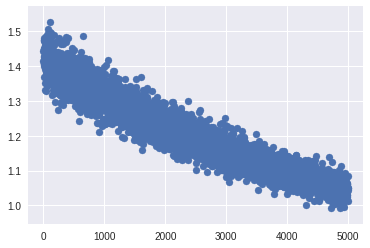

In [73]:
x = range(len(dots))
plt.scatter(x, dots)

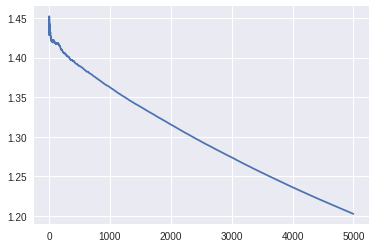

In [74]:
plt.plot(x, dots_2)

In [64]:
#torch.save(net.state_dict(), 'save_model')

In [63]:
#load_net = Net(raw_pay_train.user_id.unique().shape[0], 57)
#load_net.load_state_dict(torch.load('save_model')
#get_range_user(474)
#get_range_user(474, net=load_net)

In [60]:
def get_prediction(user_id, left, right, net=net):
    if left == -1:
        return Variable(torch.FloatTensor([-1]))
    if right == -1:
        return Variable(torch.FloatTensor([1]))
    # get random batch 
    user_ids = Variable(torch.from_numpy(get_users_map(np.array([user_id]).astype(int))))
    left_ids = Variable(torch.from_numpy(np.array([left]).astype(int)))
    right_ids = Variable(torch.from_numpy(np.array([right]).astype(int)))
    
    embedding_user = net.user_latents(user_ids)
    #print('embedded user ids: ',embedding_user)
    embedding_left = net.item_latents(left_ids)
    embedding_right = net.item_latents(right_ids) 
    #print(embedding_user, embedding_left, embedding_right)
    
    xr = torch.cat((embedding_user,embedding_right), dim=1)
    xl = torch.cat((embedding_user,embedding_left), dim=1)
    
    # get predictions
    # А здесь от i отнимаем i*
    # Убрали 
    net_margins = net.forward(xl,xr)
    #print('len: ', len(net_margins))
    return net_margins

In [61]:
items_number = 56
#items=list(range(items_number))
items=list(range(15))
from numba import int32
from collections import deque

def get_range_user(user_id=1, top=10, items=items, net=net):
    res = deque([-1] * top)
    i_s = 0
    s = 2
    if top > 1:
        if get_prediction(user_id, items[0], items[1], net=net) > get_prediction(user_id, items[1], items[0], net=net):
            res[0] = items[0]
            res[1] = items[1]
            i_s = items[0]
        else:
            res[0] = items[1]
            res[1] = items[0]
            i_s = items[1]
    else:
        s = 1
        res[0] = items[0]
    k = top - 1
    for i in items[s:]:
        i_s = res[0]
        j = top - 1
        while((j >= 0) and (get_prediction(user_id, i, res[j], net=net).data.numpy() >= 0.)):
            j -= 1
        if j < k:
            #right(res, j)
            res.insert(j+1, i)
            res.pop()
    return res

In [62]:
raw_pay_train[raw_pay_train.user_id==184].values[0][1:].argsort()[-5:][::-1]

array([37,  4, 25,  0, 14])

In [63]:
us1 = raw_pay_train.user_id.unique()
us2 = raw_pay_test.user_id.unique()

In [64]:
raw_pay_test.user_id.unique().shape

(300000,)

In [84]:
from numba import int32
from collections import deque

def my_NDCG(target_number=10, users=raw_pay_test.user_id.unique()[:6000], net=net):
    train_users = set(raw_pay_train.user_id.unique())
    d_test = raw_pay_test
    pre=0
    n_users = 0
    DCG_ = []
    logs = [1./np.log2(ind + 2) for ind in range(target_number)]
    norm = np.sum(logs)
    for user in users:
        # ????? 
        if (user in train_users and raw_pay_test[raw_pay_test.user_id==user].values[0][1:].nonzero()[0].shape[0] >= target_number):
            n_users += 1 
            #ur_prediction = get_range_user(user, target_number, net=net)
            our_prediction = [1, 2, 0, 3, 5]
            good_range = raw_pay_train[raw_pay_train.user_id==user].values[0][1:].argsort()[-target_number:][::-1]
            if pre < 10000:
                pre += 1
                if pre %100 == 0:
                    print("our: ", our_prediction, '\n', "good: ", good_range)
            # Считаем что i только 1 или 0
            DCG = 0
            for ind, item in enumerate(our_prediction):
                v = logs[ind]
                if item in good_range:
                    DCG += v
            DCG_.append(DCG)
        else:
            continue
    mean = np.mean(DCG_) / norm
    print("users: ", n_users, " mean NDCG: ", mean)
    return mean

In [85]:
%%time
ndcg = my_NDCG(target_number=5)

our:  [1, 2, 0, 3, 5] 
 good:  [21  6  0 15 24]
our:  [1, 2, 0, 3, 5] 
 good:  [ 2  5  0  4 15]
our:  [1, 2, 0, 3, 5] 
 good:  [ 3  1 26  8  0]
our:  [1, 2, 0, 3, 5] 
 good:  [ 2  9  0 15 14]
our:  [1, 2, 0, 3, 5] 
 good:  [41  1  8 24 43]
our:  [1, 2, 0, 3, 5] 
 good:  [ 5  3 56 14 25]
our:  [1, 2, 0, 3, 5] 
 good:  [ 1  9  0 15 14]
our:  [1, 2, 0, 3, 5] 
 good:  [13  3  0  2 15]
our:  [1, 2, 0, 3, 5] 
 good:  [ 1 13 14 25 24]
users:  957  mean NDCG:  0.456710776002
CPU times: user 6.12 s, sys: 16 ms, total: 6.13 s
Wall time: 6.14 s


In [70]:
from numba import int32
from collections import deque

def my_NDCG(target_number=10, users=raw_pay_test.user_id.unique()[:6000], net=net):
    train_users = set(raw_pay_train.user_id.unique())
    d_test = raw_pay_test
    pre=0
    n_users = 0
    DCG_ = []
    logs = [1./np.log2(ind + 2) for ind in range(target_number)]
    norm = np.sum(logs)
    for user in users:
        # ????? 
        if (raw_pay_train[raw_pay_train.user_id==user].values[0][1:].nonzero()[0].shape[0] >= target_number):
            n_users += 1 
            our_prediction = get_range_user(user, target_number, net=net)
            
            good_range = raw_pay_train[raw_pay_train.user_id==user].values[0][1:].argsort()[-target_number:][::-1]
            if pre < 10000:
                pre += 1
                if pre %100 == 0:
                    print("our: ", our_prediction, '\n', "good: ", good_range)
            # Считаем что i только 1 или 0
            DCG = 0
            for ind, item in enumerate(our_prediction):
                v = logs[ind]
                if item in good_range:
                    DCG += v
            DCG_.append(DCG)
        else:
            continue
    mean = np.mean(DCG_) / norm
    print("users: ", n_users, " mean NDCG: ", mean)
    return mean

In [71]:
train_users = set(raw_pay_train.user_id.unique())

In [72]:
3854 in train_users

True

In [73]:
users_map[3854]

KeyError: 3854

In [96]:
def Next_transaction_test(target_number=1, users=d_test.user_id.unique(), net=net):
    us_number = 0
    concurrences = 0
    for user in users:
        our_prediction = get_range_user(user, target_number, net=net)
        if d_test[d_test.user_id == user].shape[0] == 0:
            continue
        next_transaction = d_test[d_test.user_id == user]['KPI_CAT_l'].values[0]
        us_number += 1
        if next_transaction in our_prediction:
            concurrences += 1
    accuracy = concurrences / us_number
    print("number quessed: ", concurrences, "percent: ", accuracy)
    return accuracy

In [99]:
%%time
Next_transaction_test(target_number=3)

number quessed:  4120 percent:  0.6198284940574695
CPU times: user 57.1 s, sys: 8 ms, total: 57.1 s
Wall time: 57.1 s


0.6198284940574695

In [27]:
category_mapping = {'IP-телефония': 20.0,
 'MLM': 39.0,
 'Sim-карты для туристов': 40.0,
 'empty_kpi_cat': 17.0,
 'p2p': 41.0,
 'Абонентское обслуживание': 24.0,
 'Авиабилеты': 27.0,
 'Билеты в кино': 30.0,
 'Билеты на зрелища': 19.0,
 'Благотворительность': 28.0,
 'Бронирование гостиниц': 35.0,
 'Букмекеры': 1.0,
 'Госуслуги': 16.0,
 'Грузоперевозки и доставка': 11.0,
 'Переводы': 48.0,
 'Ж/Д билеты': 26.0,
 'ЖКУ': 42.0,
 'Игры со ставками': 4.0,
 'Интернет': 15.0,
 'Интернет магазины': 2.0,
 'Информационные услуги': 6.0,
 'Контент': 7.0,
 'Купоны': 23.0,
 'Лотереи': 5.0,
 'Международная/междугородняя связь': 36.0,
 'Местная связь': 43.0,
 'Образовательные услуги': 25.0,
 'Онлайн игры': 0.0,
 'Онлайн общение': 8.0,
 'Оплата подписки': 31.0,
 'Охранные системы': 45.0,
 'Переводы без открытия счета по свободным реквизитам': 44.0,
 'Погашение займов': 12.0,
 'Кредиты': 49.0,
 'Радио': 38.0,
 'Регистрация доменов': 22.0,
 'Ритуальные услуги': 46.0,
 'Служебная': 32.0,
 'Создание и дизайн сайтов, трафик': 18.0,
 'Сотовая связь': 13.0,
 'Страхование': 34.0,
 'Такси': 10.0,
 'Телевидение': 21.0,
 'Технический осмотр': 47.0,
 'Транспортные карты': 29.0,
 'Туристический продукт': 33.0,
 'Файлообмен': 37.0,
 'Форекс': 9.0,
 'Хостинг': 14.0,
 'Электронные деньги': 3.0}

In [225]:
raw_pay_test.category.unique()

array(['Переводы', 'ЖКУ', 'Кредиты', 'Интернет'], dtype=object)

In [ ]:
category_numbers = [48.0, ]

In [250]:
# нужном менять параметры сети и подавать туда все что есть.
def Communication_test(target_number=5, net=net): 
    load_users = load_data.user_id.unique()
    for category in raw_pay_test.category.unique():
        same_c = 0
        find_c = 0
        print("Категория: ", category)
        current_users = raw_pay_test[raw_pay_test.category == category].user_id.unique()
        print("Пользователей: ", len(current_users))
        for user in current_users:
            if user not in load_users:
                continue
            our_prediction = get_range_user(user, target_number, net=net)
            cat_index = category_mapping[category]
            for item in our_prediction:
                if item == cat_index:
                    same_c += 1
                    if category == 'Переводы':
                        if (raw_pay_test[raw_pay_test.category == category & raw_pay_test.user_id==user, 
                                     transfer_pay_30].values[0] == 1):
                            find_c += 1
                    elif category == 'ЖКУ': 
                        if (raw_pay_test[raw_pay_test.category == category & raw_pay_test.user_id==user, util_30].values[0] == 1):
                            find_c += 1
                    elif category == 'Кредиты': 
                        # тут нужно добавить еще одну строку со второй колонкой
                        if (raw_pay_test[raw_pay_test.category == category & raw_pay_test.user_id==user, 
                                         loan_pay_30].values[0] == 1):
                            find_c += 1
                    # Интернет
                    else: 
                        if (raw_pay_test[raw_pay_test.category == category & raw_pay_test.user_id==user, 
                                         internet_pay_30].values[0] == 1):
                            find_c += 1
                    break
        print("Совпадает: ", same_c, "Из них ответили на: ", find_c)